In [ ]:
!pip install qiskit-aer -q
!pip install qiskit-ibm-runtime -q
!pip install pylatexenc -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.2/366.2 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 10.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Import Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
from qiskit_ibm_runtime.fake_provider import FakeVigoV2
from qiskit.visualization import plot_gate_map

In [ ]:
# --- Modular Qiskit demo with pluggable fake backends ---

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_gate_map
from IPython.display import display
import matplotlib.pyplot as plt

# 1) Circuit builder
def create_circuit(circuit: QuantumCircuit | None = None, qubits: int = 3, graph: bool = True) -> QuantumCircuit:
    """
    - Si 'circuit' se pasa, se usa ese circuito.
    - Si no, se crea uno nuevo con 'qubits' (>=3 para este ejemplo) y se aplica la misma secuencia de compuertas.
    """
    if circuit is None:
        if qubits < 3:
            raise ValueError("Este circuito de ejemplo requiere al menos 3 qubits.")
        circuit = QuantumCircuit(qubits)
        circuit.h(0)
        circuit.x(0)
        circuit.x(1)
        circuit.z(2)
        circuit.cx(0, 1)
        circuit.measure_all()
    if circuit is None:
        raise ValueError(f"No se especificó el parametro 'circuit'.")

    if graph:
        fig = circuit.draw("mpl")
        display(fig)
        fig.savefig("circuito_original.png", dpi=300, bbox_inches="tight")
        plt.close(fig)

    return circuit

# 2) Fake backend (forzamos Vigo)
def get_fake_backend(backendName: str | None = None):
    """Devuelve una instancia del fake backend Vigo (V2 si existe, si no legacy).
    Lanza excepción si backendName no es Vigo."""
    if backendName is not None and backendName.lower() != "vigo":
        raise ValueError(f"Solo está implementado el backend 'Vigo' en esta versión. Se recibió: {backendName}")

    try:
        from qiskit_ibm_runtime.fake_provider import FakeVigoV2
        return FakeVigoV2()
    except Exception:
        from qiskit.providers.fake_provider import FakeVigo
        return FakeVigo()

# 3) Backends (ideal & noisy)
def setup_backends(device_backend, seed: int | None = None):
    simulator = AerSimulator(seed_simulator=seed)
    sim_noisy = AerSimulator.from_backend(device_backend)
    if seed is not None:
        sim_noisy.set_options(seed_simulator=seed)
    return simulator, sim_noisy

# 4) Transpile for noisy backend
def transpile_for_noisy_backend(original_circuit: QuantumCircuit, sim_noisy: AerSimulator) -> QuantumCircuit:
    return transpile(original_circuit, sim_noisy)

# 5) Render transpiled
def render_transpiled(transpiled_circuit: QuantumCircuit):
    fig = transpiled_circuit.draw("mpl", style="iqp"); display(fig)
    fig.savefig("circuito_transpilado.png", dpi=300, bbox_inches="tight"); plt.close(fig)

# 6) Device topology
def plot_device_topology(device_backend):
    fig = plot_gate_map(device_backend); display(fig)
    fig.savefig("topologia_backend.png", dpi=300, bbox_inches="tight"); plt.close(fig)

# 7) Run ideal
def run_ideal(original_circuit: QuantumCircuit, simulator: AerSimulator, shots: int):
    result = simulator.run(original_circuit, shots=shots).result()
    counts = result.get_counts(original_circuit)
    fig = plot_histogram(counts, title="Ejecución sin ruido"); display(fig)
    fig.savefig("ejecucion_sin_ruido.png", dpi=300, bbox_inches="tight"); plt.close(fig)
    return counts

# 8) Run noisy
def run_noisy(transpiled_circuit: QuantumCircuit, sim_noisy: AerSimulator, shots: int):
    result = sim_noisy.run(transpiled_circuit, shots=shots).result()
    counts = result.get_counts()
    fig = plot_histogram(counts, title="Ejecución con ruido"); display(fig)
    fig.savefig("ejecucion_con_ruido.png", dpi=300, bbox_inches="tight"); plt.close(fig)
    return counts

# 9) Optional: auto-download PNGs (Colab-safe)
def download_pictures_pngs():
    try:
        from google.colab import files
        for f in [
            "circuito_original.png",
            "circuito_transpilado.png",
            "topologia_backend.png",
            "ejecucion_sin_ruido.png",
            "ejecucion_con_ruido.png",
        ]:
            files.download(f)
    except Exception:
        pass

# 10) Orchestrator
def main(circuit, backend_name: str = "Vigo", shots: int = 1024, seed: int | None = 42,
         download_pictures: bool = False):
    device_backend = get_fake_backend(backend_name)        # ahora siempre Vigo (V2 o legacy)
    simulator, sim_noisy = setup_backends(device_backend, seed=seed)

    circ = create_circuit(circuit, graph=True)
    transpiled = transpile_for_noisy_backend(circ, sim_noisy)
    render_transpiled(transpiled)
    plot_device_topology(device_backend)

    _ = run_ideal(circ, simulator, shots=shots)
    _ = run_noisy(transpiled, sim_noisy, shots=shots)

    if download_pictures:
        download_pictures_pngs()

# Ejecutá:
# main()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

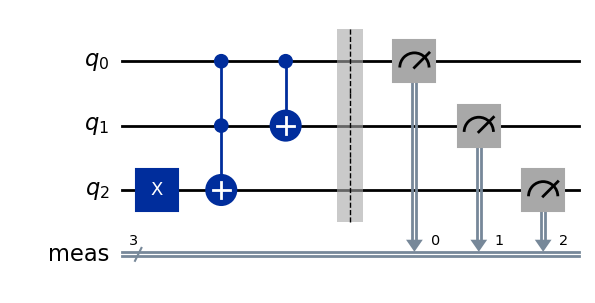

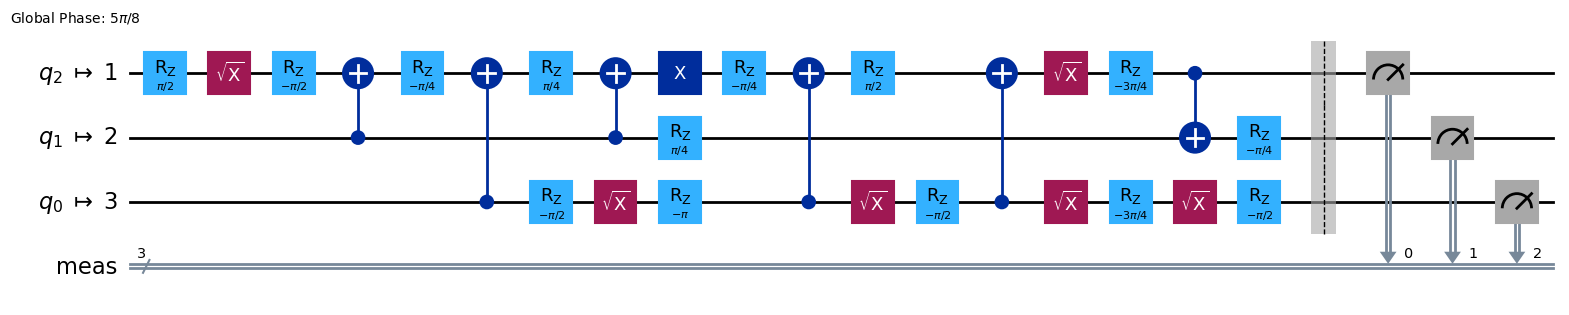

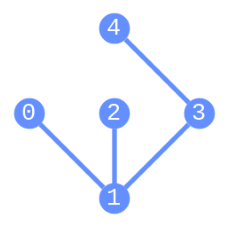

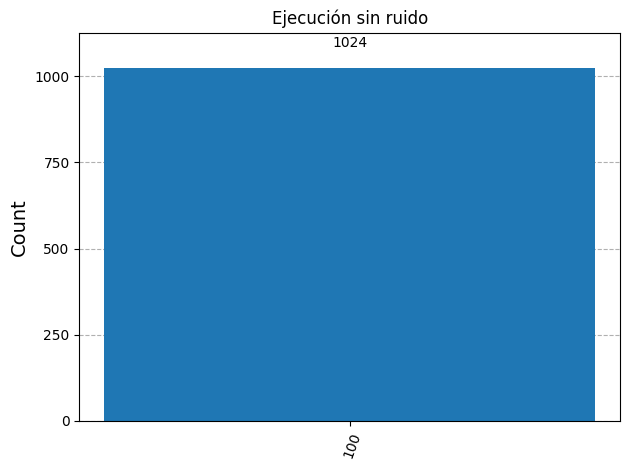

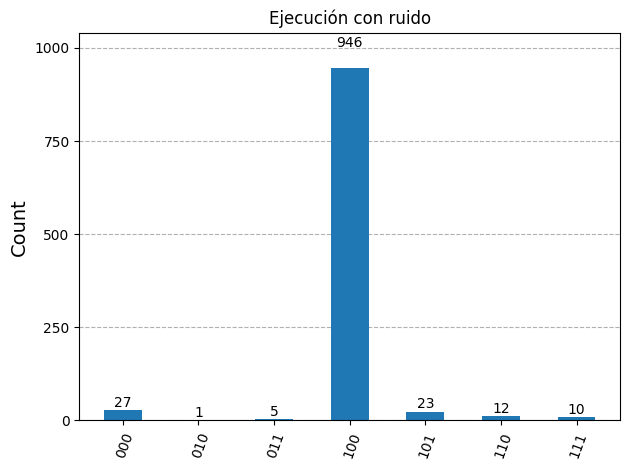

In [ ]:
circ = QuantumCircuit(3)
circ.x(2)
circ.ccx(0, 1,2)
circ.cx(0,1);

circ.measure_all()

main(circ, download_pictures=False)